In [ ]:
import cv2                          # Main OpenCV library
import numpy as np                  # For array operations
import matplotlib.pyplot as plt     # For nice visualization

In [ ]:
def load_and_prepare_image(image_path):
    """
    Load color image and convert to grayscale.
    Many feature detectors work on grayscale images.
    """
    img_color = cv2.imread(image_path)                      # Read image in BGR format
    if img_color is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")


    img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)  # Convert BGR → Grayscale
    return img_color, img_gray                                  # Return both versions



# SIFT

### Understanding SIFT
Imagine this situation

You take two photos of the same building:

Photo 1: close-up, straight

Photo 2: far away, rotated a bit, taken at evening

They look different to a computer:

* size is different
* angle is different
* brightness is different

SIFT’s job is to say:
👉 “These two photos show the same building”

### STEP BY STEP

1. **Look at the image in many sizes (Scale-space)**
  * Takes the image
  * Makes many blurry versions
    * slightly blurry
    * more blurry
    * very blurry
  * Each blur = looking at the image from farther away.


2. **Find “interesting points” (Keypoint detection)**
  * It subtracts two blurry images → Difference of Gaussian
  * This highlights corners and blobs
  * A pixel is compared with neighbors:
    * left–right
    * above–below
    * smaller blur
    * bigger blur


3. **Throw away bad points (Keypoint localization)**

* SIFT:
    * removes low-contrast points
    * removes edge-only points


4. **Give each point a direction (Orientation)**
* For each keypoint:
    * looks around it
    * checks which direction edges point the most
    * Eg: most edges point northeast → orientation = northeast


5. **Describe what’s around the point (Descriptor)**
  * Takes a 16×16 square around the point
  * Splits it into 16 small squares
  * For each square: counts edge directions
  * This becomes the fingerprint of that point.


6. **Match points between images (Matching)**


In [ ]:
def detect_and_compute_sift(gray_img):
    """
    Detect keypoints and compute SIFT descriptors.
    SIFT is scale & rotation invariant, 128-float descriptor.
    """
    sift = cv2.SIFT_create()                            # Create SIFT detector object (OpenCV ≥4.4)
    # You can tune parameters: nfeatures, nOctaveLayers, contrastThreshold, etc.
    # sift = cv2.SIFT_create(nfeatures=500, contrastThreshold=0.04)

    keypoints, descriptors = sift.detectAndCompute(gray_img, None)
    # detectAndCompute() does both detection + description in one call
    # None = no mask (use whole image)

    return keypoints, descriptors


# ORB

In [ ]:
def detect_and_compute_orb(gray_img, nfeatures=1500):
    """
    Detect keypoints and compute ORB (binary) descriptors.
    ORB is very fast, rotation-aware, binary (Hamming distance matching).
    """
    orb = cv2.ORB_create(nfeatures=nfeatures)           # Limit max number of features
    # Other useful params: scaleFactor=1.2, nlevels=8, edgeThreshold=31, scoreType=cv2.ORB_HARRIS_SCORE

    keypoints, descriptors = orb.detectAndCompute(gray_img, None)
    # Returns: list of KeyPoint objects + binary descriptor array (uint8)

    return keypoints, descriptors


# SURF

SURF (Speeded Up Robust Features) is a feature detection + description algorithm, like SIFT, but designed to be much faster.

It has two main stages:

Feature Extraction → Where are the interesting points?

Feature Description → How does the area around each point look?

### STEP BY STEP

1. Detection: Use Fast-Hessian detector (approximated box filters on integral images) for blob-like keypoints across scales.

2. Orientation Assignment: Haar-wavelet responses in a circular neighbourhood to assign the dominant direction.

3. Descriptor Generation: In a square region aligned to orientation, compute Haar-wavelet responses (dx, dy) in 4x4 sub-regions, sum dx, dy, |dx|, |dy| → 64-dimensional vector (extendable to 128).


In [ ]:
def detect_and_compute_surf(gray_img):
    """
    Attempt to use SURF (Speeded-Up Robust Features).
    WARNING: Often raises exception in standard pip installs because patented.
    Only works if OpenCV was built with OPENCV_ENABLE_NONFREE=ON + contrib modules.
    """
    try:
        surf = cv2.xfeatures2d.SURF_create()            # SURF is in xfeatures2d module
        # surf.setExtended(1)                           # Optional: 128-dim instead of 64
        # surf.setHessianThreshold(400)

        keypoints, descriptors = surf.detectAndCompute(gray_img, None)
        return keypoints, descriptors
    except AttributeError:
        print("SURF is not available in this OpenCV build (patented / non-free).")
        print("Use SIFT or ORB instead for this demonstration.")
        return [], None
    except cv2.error as e:
        print("SURF error:", e)
        print("Likely need to compile OpenCV with non-free flag.")
        return [], None


In [ ]:
def draw_keypoints(img_color, keypoints, title="Keypoints"):
    """
    Draw detected keypoints on the color image for visualization.
    """
    img_with_kp = cv2.drawKeypoints(
        img_color,
        keypoints,
        None,                                   # output image (None = create new)
        color=(0, 255, 0),                      # green circles
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        # shows orientation & scale
    )
    # Show using matplotlib (handles RGB conversion)
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

Image loaded: (640, 640)

Computing SIFT...
SIFT → 1503 keypoints found


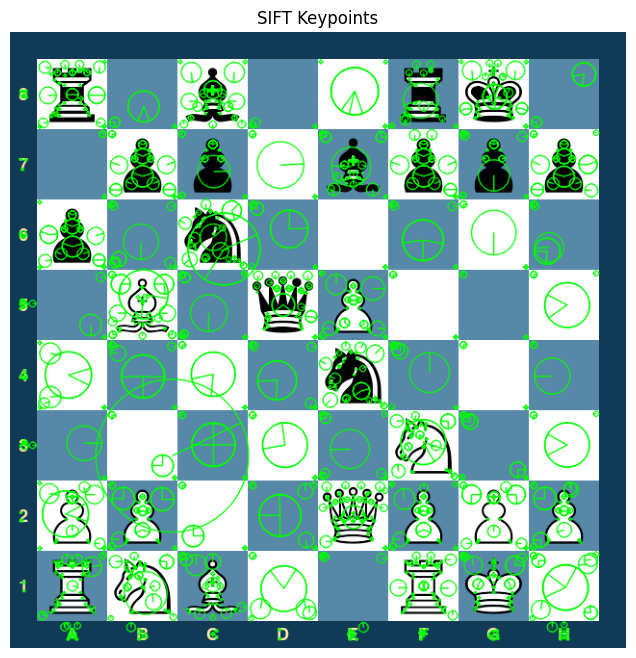


Computing ORB...
ORB  → 2001 keypoints found


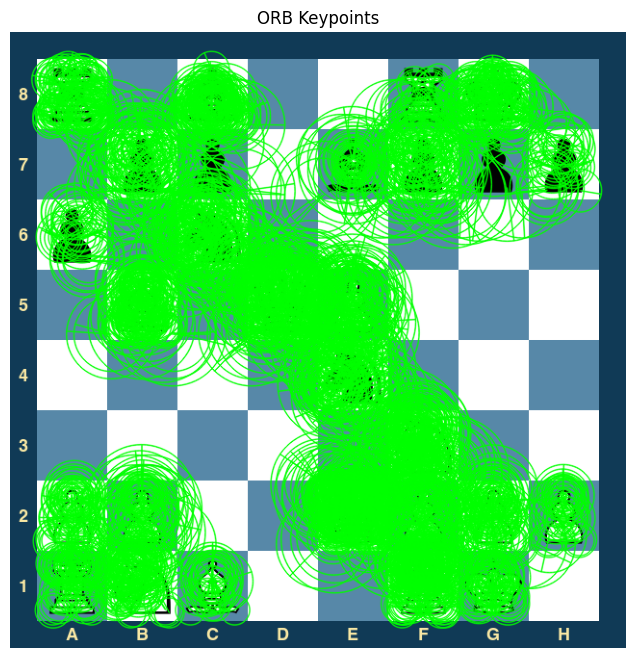


Trying SURF (may not be available)...
SURF error: OpenCV(4.13.0) /io/opencv_contrib/modules/xfeatures2d/src/surf.cpp:1026: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

Likely need to compile OpenCV with non-free flag.
Skipping SURF visualization.


In [ ]:
def main():
  image_path = "/content/chess_board.png"               # ← Replace with real path
  color_img, gray_img = load_and_prepare_image(image_path)
  print(f"Image loaded: {gray_img.shape}")

  # ────────────── SIFT ─────────────────────────────
  print("\nComputing SIFT...")
  kp_sift, des_sift = detect_and_compute_sift(gray_img)
  print(f"SIFT → {len(kp_sift)} keypoints found")

  if kp_sift:
    draw_keypoints(color_img, kp_sift, "SIFT Keypoints")

  # ────────────── ORB ──────────────────────────────
  print("\nComputing ORB...")
  kp_orb, des_orb = detect_and_compute_orb(gray_img, nfeatures=2000)
  print(f"ORB  → {len(kp_orb)} keypoints found")

  if kp_orb:
    draw_keypoints(color_img, kp_orb, "ORB Keypoints")


  # ────────────── SURF (may fail) ──────────────────
  print("\nTrying SURF (may not be available)...")
  kp_surf, des_surf = detect_and_compute_surf(gray_img)
  if kp_surf:
      print(f"SURF → {len(kp_surf)} keypoints found")
      draw_keypoints(color_img, kp_surf, "SURF Keypoints")
  else:
      print("Skipping SURF visualization.")

# Call the main function to execute the image processing workflow
main()

# Task :
* Feature matching between two images
* BFMatcher + ratio test
* drawMatches visualization

In [ ]:
image_path_2 = "/content/chess_board (1).png" # Define the path for the second image using an available file
color_img2, gray_img2 = load_and_prepare_image(image_path_2)
print(f"Second image loaded: {gray_img2.shape}")

Second image loaded: (640, 640)


In [ ]:
print("\nComputing SIFT for first image...")
kp_sift1, des_sift1 = detect_and_compute_sift(gray_img)
print(f"SIFT (Image 1) → {len(kp_sift1)} keypoints found")

print("\nComputing SIFT for second image...")
kp_sift2, des_sift2 = detect_and_compute_sift(gray_img2)
print(f"SIFT (Image 2) → {len(kp_sift2)} keypoints found")


Computing SIFT for first image...
SIFT (Image 1) → 1503 keypoints found

Computing SIFT for second image...
SIFT (Image 2) → 1503 keypoints found


In [ ]:
def bf_matcher_ratio_test(des1, des2):
    """
    Performs Brute-Force (BF) matching with Lowe's ratio test.
    """
    # 1. Instantiate a cv2.BFMatcher object.
    # SIFT uses floating-point descriptors, so NORM_L2 is appropriate.
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

    # 2. Use knnMatch() to find the 2 best matches for each descriptor.
    # It returns k=2 nearest neighbors.
    matches = matcher.knnMatch(des1, des2, k=2)

    # 3. Apply Lowe's ratio test.
    good_matches = []
    # Ensure there are at least two matches for ratio test
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    # 4. Return the list of good matches.
    return good_matches


# Perform matching for SIFT descriptors
good_matches_sift = bf_matcher_ratio_test(des_sift1, des_sift2)
print(f"Found {len(good_matches_sift)} good matches using SIFT and Ratio Test.")

Found 1176 good matches using SIFT and Ratio Test.


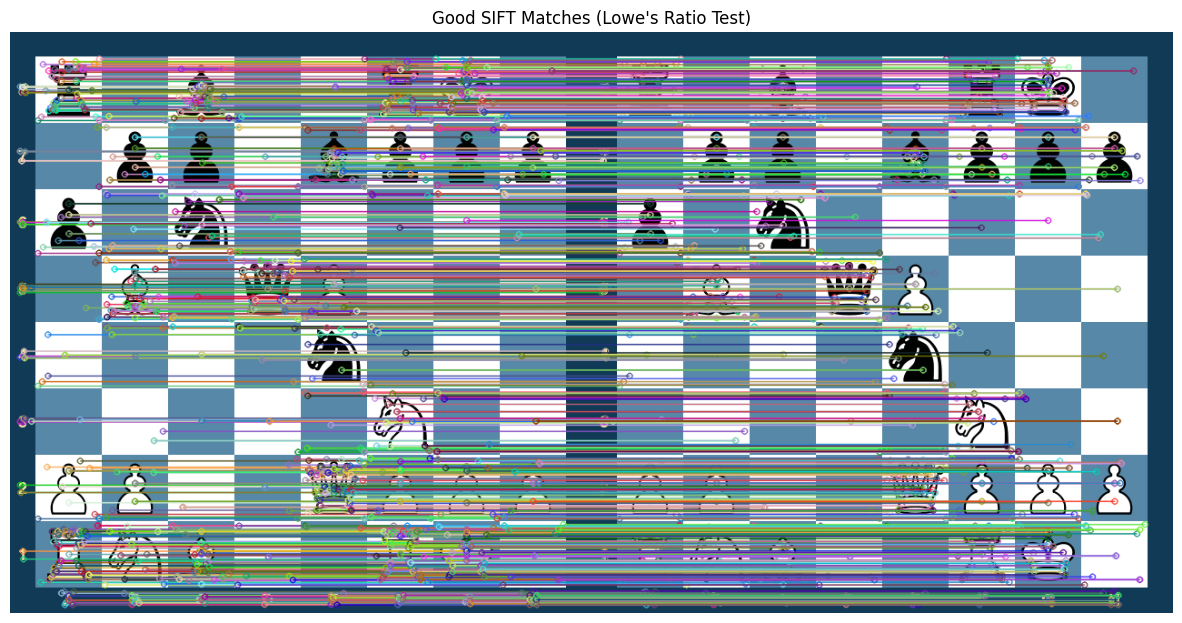

In [ ]:
matched_img = cv2.drawMatches(
    color_img,
    kp_sift1,
    color_img2,
    kp_sift2,
    good_matches_sift,
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("Good SIFT Matches (Lowe's Ratio Test)")
plt.axis('off')
plt.show()